In [27]:
#Installing required package
#This installs the bayesian optimization package which is used for BO implementation.
%pip install bayesian-optimization==1.4.1


Note: you may need to restart the kernel to use updated packages.


# Importing the packages

In [28]:
#Importing necessary libraries 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import pandas as pd
from bayes_opt.util import UtilityFunction


# Data Loading & Pre Processing

In [29]:
# Loading the protein data from a CSV file (contains all the molecular information)
#The protein data is loaded from a csv file into a pandas DataFrame called protein_data.

protein_data=pd.read_csv(r"/Users/himaniaryan/Desktop/Himani Bayesian New 5/FSMOL_Protein_Data.csv")


In [30]:
# Dropping rows with null values in the 'reliable_target_protein_super' column

protein_data1 = protein_data.dropna(axis=0, subset=['reliable_target_protein_super'])

In [31]:
# Filling remaining NA values with 0

protein_data1=protein_data1.fillna(0)

In [32]:
#Converting some of the variables from boolean to string
#Columns containing boolean values are converted to string type to ensure consistency.

protein_data1['reliable_target_EC']=protein_data1['reliable_target_EC'].astype(str)
protein_data1['reliable_target_protein_desc']=protein_data1['reliable_target_protein_desc'].astype(str)
protein_data1['reliable_target_EC_super']=protein_data1['reliable_target_EC_super'].astype(str)
protein_data1['reliable_target_protein_super']=protein_data1['reliable_target_protein_super'].astype(str)

In [33]:
# Extracting feature and target data
#The feature data is extracted from protein_data1 by dropping certain columns, and the
#target data is assigned to the 'target_id' column.

feature = protein_data1.drop(['chembl_id','target_id','component_synonym','type_synonym','protein_class_desc','pref_name','EC_super_class','EC_super_class_name','protein_family','protein_super_family','EC_name'],axis=1)
target = protein_data1['target_id']

In [34]:
#Converting the categorical features to dummy variables
#pd.get_dummies is used to perform one-hot encoding
#drop_first is used to drop the first category in each column to avoid multicollinearity

#new binary colums for each category is created
reliable_target_EC=pd.get_dummies(feature['reliable_target_EC'],drop_first=True)
reliable_target_protein_desc=pd.get_dummies(feature['reliable_target_protein_desc'],drop_first=True)
reliable_target_EC_super=pd.get_dummies(feature['reliable_target_EC_super'],drop_first=True)
reliable_target_protein_super=pd.get_dummies(feature['reliable_target_protein_super'],drop_first=True)

In [35]:
#Renaming the columns of the dummy variable DataFrames
#Renaming brings in more clarity and interpretability

reliable_target_EC.columns = [f"EC_{col}" for col in reliable_target_EC.columns]
reliable_target_protein_desc.columns = [f"protein_desc_{col}" for col in reliable_target_protein_desc.columns]
reliable_target_EC_super.columns = [f"EC_super_{col}" for col in reliable_target_EC_super.columns]
reliable_target_protein_super.columns = [f"protein_super_{col}" for col in reliable_target_protein_super.columns]

In [36]:
#Dropping the undersired feature variables

feature.drop(['reliable_target_EC','reliable_target_protein_desc','reliable_target_EC_super','reliable_target_protein_super'],axis=1,inplace=True)

In [37]:
#Concating the feature variable with created dummies
#concating the feature variables with the feature variables that were formed via one-hot encoding

feature = pd.concat([feature,reliable_target_EC,reliable_target_protein_desc,reliable_target_EC_super,reliable_target_protein_super],axis=1)

In [38]:
feature

,confidence,EC_True,protein_desc_True,EC_super_True,protein_super_True
7,4,1,1,1,1
8,4,1,1,1,1
12,4,1,1,1,1
13,4,1,1,1,1
14,4,1,1,1,1
...,...,...,...,...,...
4921,9,1,1,1,1
4924,9,0,1,0,1
4927,9,1,1,1,1
4933,9,1,1,1,1


In [39]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 7 to 4934
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   confidence          3040 non-null   int64
 1   EC_True             3040 non-null   uint8
 2   protein_desc_True   3040 non-null   uint8
 3   EC_super_True       3040 non-null   uint8
 4   protein_super_True  3040 non-null   uint8
dtypes: int64(1), uint8(4)
memory usage: 59.4 KB


In [40]:
# Assuming 'feature' is the DataFrame
columns_to_convert = [1, 2, 3, 4]  # Listing the column indices for conversion 

for col_idx in columns_to_convert:
    feature.iloc[:, col_idx] = feature.iloc[:, col_idx].astype(int)

# Now the data types of the specified columns will be changed to integer


/var/folders/9b/l512hjbd4rs6skrs9_588p1h0000gn/T/ipykernel_80541/727381222.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature.iloc[:, col_idx] = feature.iloc[:, col_idx].astype(int)


# EDA

In [41]:
#EDA for proper understanding of the dataset

feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 7 to 4934
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   confidence          3040 non-null   int64
 1   EC_True             3040 non-null   int64
 2   protein_desc_True   3040 non-null   int64
 3   EC_super_True       3040 non-null   int64
 4   protein_super_True  3040 non-null   int64
dtypes: int64(5)
memory usage: 142.5 KB


In [42]:
feature.describe()

,confidence,EC_True,protein_desc_True,EC_super_True,protein_super_True
count,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000
mean,8.391118,0.827303,0.956579,0.976316,0.989474
std,0.998512,0.378048,0.203837,0.152088,0.102073
min,4.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1.000000,1.000000,1.000000,1.000000
50%,9.000000,1.000000,1.000000,1.000000,1.000000
75%,9.000000,1.000000,1.000000,1.000000,1.000000
max,9.000000,1.000000,1.000000,1.000000,1.000000


## Visualization 1: Distribution of the Target Variable

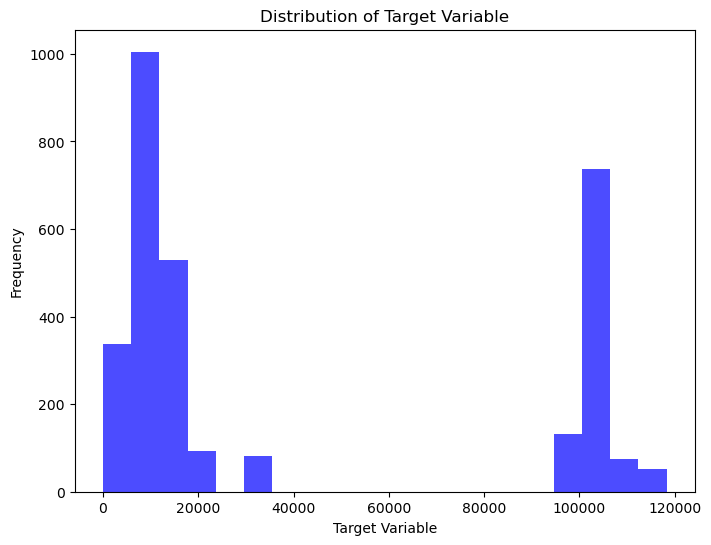

In [43]:
plt.figure(figsize=(8, 6))
plt.hist(target, bins=20, color='blue', alpha=0.7)
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

## Visualization 2: Correlation Matrix Heatmap

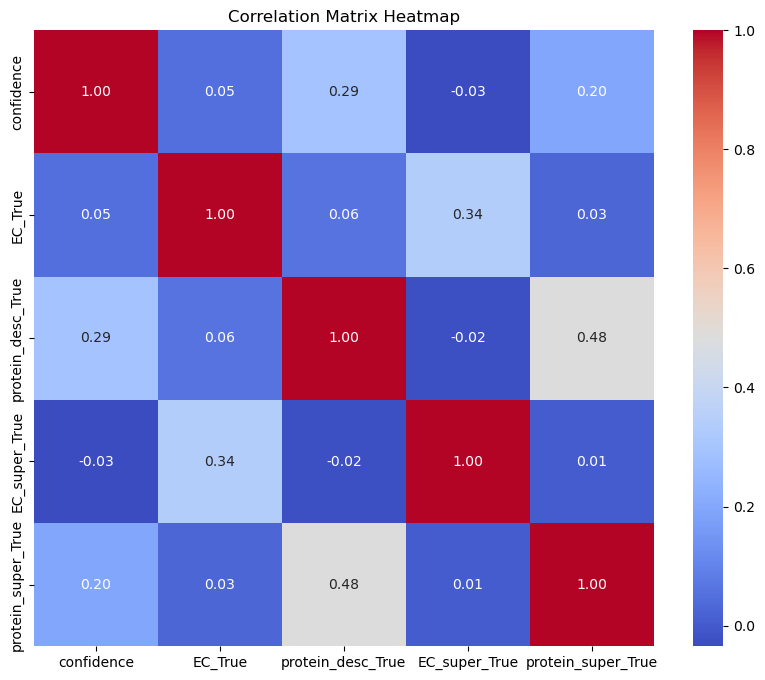

In [44]:
correlation_matrix = feature.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# Split the data into training and testing sets

In [45]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

# Scaling the features to ensure same inflluence of all the features on the optimization process.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the black-box function (objective to be maximized)

In [46]:
#defining a black box function
#this function uses SVR for modelling relationship between features and target values.

def black_box_function(C):
    model = SVR(C=C)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return -mean_squared_error(y_test, y_pred)  # Negative MSE for maximization

# Set the hyperparameter bounds for optimization

In [47]:
#setting parameter bounds which will be optimized using bayesian optimization
pbounds = {"C": (0.1, 10.00)}

# Define the Bayesian Optimization optimizer

In [48]:
#defining the bayesian optimization optimizer
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=4,
    allow_duplicate_points=True
)

# Acquisition functions

In [49]:
#defining different acquisition functions like EI, POI, UCB.
#these functions balances out exploration and exploitation and hence guides the optimization process.

def expected_improvement(mean, std, max_target):
    z = (max_target - mean) / std
    return (max_target - mean) * norm.cdf(z) + std * norm.pdf(z)

def probability_of_improvement(mean, std, max_target):
    z = (max_target - mean) / std
    return norm.cdf(z)

def upper_confidence_bound(mean, std, max_target, kappa=2.0):
    return mean + kappa * std


# Main optimization loop
acquisition_functions = [expected_improvement, probability_of_improvement, upper_confidence_bound]
acquisition_names = ["EI", "POI", "UCB"]

# Defining Molecule Sampling

In [50]:
#defining molecule sampling
def sample_new_molecule(pbounds, num_samples=10):
    x_samples = []
    for _ in range(num_samples):
        x_sample = []
        for param_name in pbounds.keys():
            param_range = pbounds[param_name]
            x_param = np.random.uniform(param_range[0], param_range[1])
            x_sample.append(x_param)
        x_samples.append(x_sample)
    return np.array(x_samples)


# Initialize potential_points

In [51]:
# Initializing potential_points
potential_points = np.random.uniform(pbounds["C"][0], pbounds["C"][1], size=10)

# Main optimization loop

Running optimization with EI acquisition function...
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
Optimization with EI acquisition function finished.



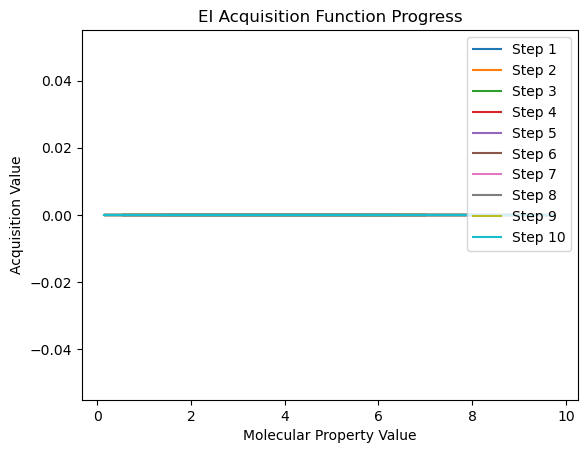

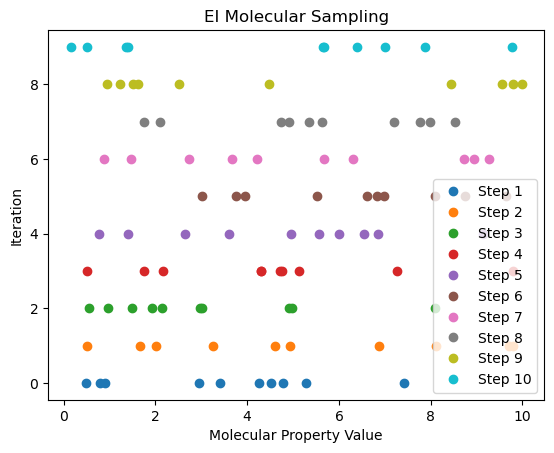

Best result for EI acquisition: {'C': 9.6735954062354} with target value -3014652745.2175913
Running optimization with POI acquisition function...
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
Optimization with POI acquisition function finished.



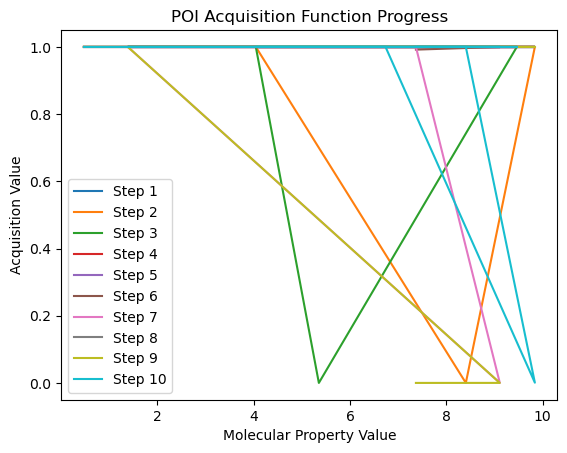

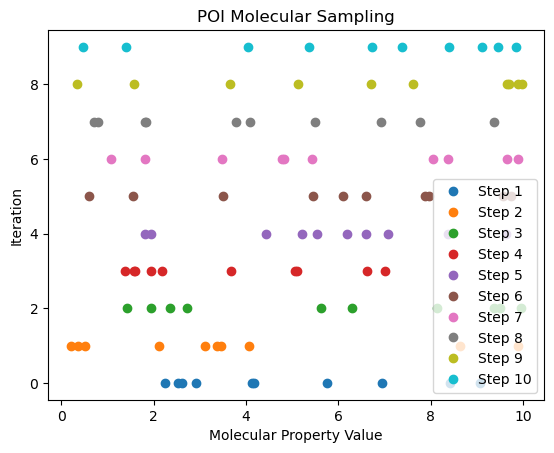

Best result for POI acquisition: {'C': 9.754489008521569} with target value -3014557008.4700437
Running optimization with UCB acquisition function...
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
Optimization with UCB acquisition function finished.



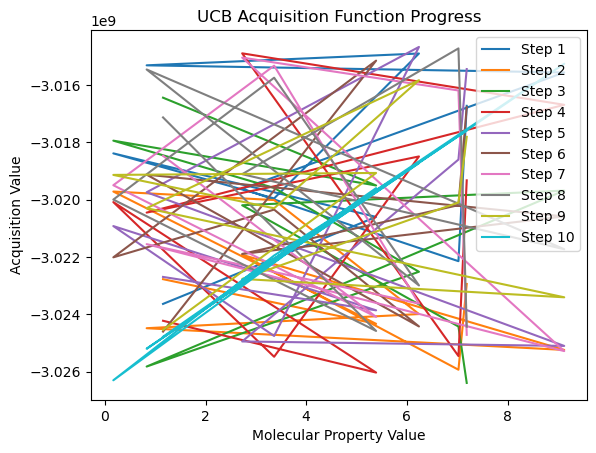

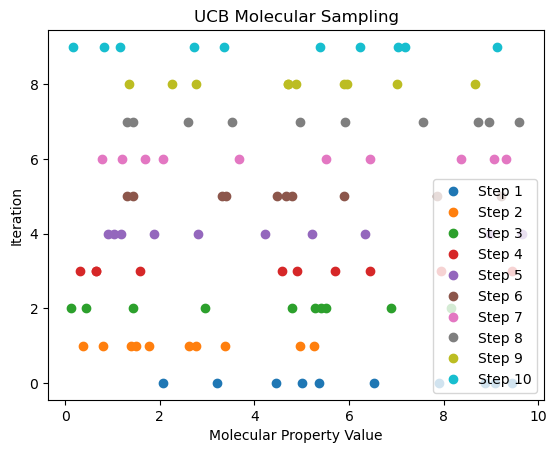

Best result for UCB acquisition: {'C': 10.0} with target value -3014174075.745982


In [52]:
#using different acquisition functions, bayesian optimization is run.
#new molecules are sampled and evaluated using these aquisition functions.

#the loop samples new molecules,evaluates their potential using acquisition functions and then selects the next
#molecule to test.

import matplotlib.pyplot as plt

# Main optimization loop
for acq_function, acq_name in zip(acquisition_functions, acquisition_names):
    print(f"Running optimization with {acq_name} acquisition function...")
    
    utility_function = UtilityFunction(kind=acq_name.lower(), kappa=2.5, xi=0.0)
    
    # Number of optimization steps
    num_steps = 10
    
    acquisition_progress = []  # Store acquisition values for each step
    molecular_samples = []     # Store sampled molecules for each step
    
    # Sample new molecules
    potential_points = sample_new_molecule(pbounds)

    # Find the best molecule using Bayesian optimization
    next_point = optimizer.suggest(utility_function)

    # Evaluate the black-box function at the suggested point
    target_value = black_box_function(next_point['C'])

    # Register the new point and target value with the optimizer
    optimizer.register(params=next_point, target=target_value)
    
    for step in range(num_steps):
        print(f"Step {step+1}/{num_steps}")
        
        # Sample new molecules
        potential_points = sample_new_molecule(pbounds)
        
        # Find the best molecule using the acquisition function
        acquisition_values = []
        for x_candidate in potential_points:
            mean, std = optimizer._gp.predict(np.array([x_candidate]), return_std=True)
            acquisition_values.append(acq_function(mean, std, optimizer.max['target']))  # Call the acq_function directly
        
        # Choose the potential point with the highest acquisition value
        next_point = potential_points[np.argmax(acquisition_values)]
        
        # Evaluate the black-box function at the suggested point
        target_value = black_box_function(**{key: value for key, value in zip(pbounds.keys(), next_point)})
        
        # Register the new point and target value with the optimizer
        optimizer.register(params={key: value for key, value in zip(pbounds.keys(), next_point)}, target=target_value)
        
        # Store acquisition values and potential points for plotting
        acquisition_progress.append(acquisition_values)
        molecular_samples.append(potential_points)
        
    print(f"Optimization with {acq_name} acquisition function finished.\n")
    
    #various plots are generated to visualise the progress of each aquisition function.
    
    # Plot acquisition function progress
    plt.figure()
    plt.title(f"{acq_name} Acquisition Function Progress")
    for i, values in enumerate(acquisition_progress):
        plt.plot(potential_points, values, label=f"Step {i+1}")
    plt.xlabel("Molecular Property Value")
    plt.ylabel("Acquisition Value")
    plt.legend()
    plt.show()
    
    # Plot molecular sampling
    plt.figure()
    plt.title(f"{acq_name} Molecular Sampling")
    for i, samples in enumerate(molecular_samples):
        plt.plot(samples, np.zeros_like(samples) + i, "o", label=f"Step {i+1}")
    plt.xlabel("Molecular Property Value")
    plt.ylabel("Iteration")
    plt.legend()
    plt.show()
    
    # Printing the best result for the current acquisition function
    best_result = optimizer.max
    print(f"Best result for {acq_name} acquisition: {best_result['params']} with target value {best_result['target']}")
